# Wideband PB Correction in CASA

Frequency dependent primary beams introduce artificial spectral structure into wide-field and mosaic images from instruments such as the VLA where broad-band data are combined to form images. This notebook contains examples of multiple ways to correct for this instrumental spectral index. 

## An example dataset 

VLA L-Band (1-2 GHz) with 2 pointings, 3 channels at 1.2, 1.5, 1.8 GHz and one point source of intensity 1 Jy and alpha = -0.5 in-between the two pointings.  

Data were simulated one channel at a time using gridder='mosaic' and a true-sky model image cube (normtype='flatsky' to apply the appropriate PB during visibility prediction). 

## Example scripts

This notebook contains examples for a variety of imaging situations that are known to work (upto some accuracy). 
    
__Single Pointing__ : 
        - Cube Imaging with per-channel PB correction (all gridders)
        - MTMFS Continuum Imaging with gridder='standard' or 'wproject' following by widebandpbcor
        - MTMFS Continuum Imaging with conjbeams ( gridder = 'mosaic' and 'awproject' )
                
__Mosaic__ : 
        - Cube Imaging with gridder='mosaic' or 'awproject'
        - MTMFS Continuum with gridder='awproject' and conjbeams=True
     

***

Wideband PB-correction may be considered experimental, with finite algorithm commissioning required before all ways of imaging these data may be equally trusted. This work is ongoing.

# Import Libraries + Setup

__Import Libraries__

In [216]:
# Import required tools/tasks
from casatools import image, table, ctsys
from casatasks import tclean, ft, imhead, listobs, casalog, widebandpbcor, impbcor

import os
import pylab as pl
import numpy as np

# Instantiate all the required tools
ia = image()
tb = table()

__Print imaging lines of a log file__

In [217]:
def printlogs(imagename=''):
    fp = open(imagename+'.log')
    for aline in fp.readlines():
        if aline.count('['+imagename) > 0 and ( aline.count("Peak residual")>0 or aline.count("iters")>0 ) :
            printstr = aline.partition( '['+imagename) 
            print(printstr[1] + printstr[2].replace('\n',''))
        if aline.count("------")>0:
            printstr = aline.partition('------ Run')
            print(printstr[1] + printstr[2].replace('\n',''))
    fp.close()

__Display an image__

Use some image viewer, or just pull the pixels out and use matplotlib or plotly

In [223]:
# Display an image cube or a single plane image.
# For a Cube, show the image at chan 0 and a spectrum at the location of the peak in chan0.
# For a Single plane image, show the image.
def dispImage(imname='sim_onepoint_true.im', withspec=False, specloc='max'):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    
    pix = pix[ int(shp[0]*0.35):int(shp[0]*0.65) ,int(shp[1]*0.35):int(shp[1]*0.65) ,:,:]
    shp = pix.shape
    
    if shp[3]==1:  # Single plane image
        pl.figure(figsize(6,6))
        pl.clf()
        pl.imshow(np.transpose(pix[:,:,0,0]), origin='lower') 
        pl.colorbar()
        pl.title('Image : '+imname)
        
    if shp[3]>1:  # Cube ( show images for all planes in a row... ) and a spectrum at the peak if needed
        nplots = shp[3]
        if withspec==True:
            nplots=shp[3]+1

        pl.figure(figsize=(nplots*4,4))
        pl.clf()
            
        pmax = pix[:,:,0,0].max()
        for chan in range(0,shp[3]):
            pl.subplot(1,nplots,chan+1)
            pl.imshow(np.transpose(pix[:,:,0,chan]), origin='lower', vmin=0.0, vmax=pmax) 
            pl.title('Image from channel '+str(chan))
            pl.colorbar()

        if withspec==True:
            pl.subplot(1,nplots,nplots)
            
            if specloc=='max':
                plocs = np.where( pix == pix.max() )
                ploc = [ plocs[0][0] , plocs[1][0] ]
            else: # plot for middle pixel
                ploc = [ int(shp[0]/2), int(shp[1]/2)]

            pl.plot(pix[ploc[0], ploc[1],0,:], 'o-')

            # Alpha calculation is HARD_CODED for 1.2 to 1.8 GHz
            alpha = ( np.log( pix[ploc[0], ploc[1],0,shp[3]-1] ) - np.log( pix[ploc[0], ploc[1],0,0] ) ) / (np.log(1.8) - np.log(1.2))
            
            pl.title('Spectrum at source ( Alpha = %2.2f )'%(alpha))
            pl.xlabel('Channel')
        
        
## Display an intensity image and a spectral index.
def dispImageAlpha(imname='', alname=''):
    ia.open(imname)
    pix1 = ia.getchunk()
    shp1 = ia.shape()
    ia.close()
    
    ia.open(alname)
    alpix1 = ia.getchunk()
    alshp1 = ia.shape()
    ia.close()
    
    pix = pix1[ int(shp1[0]*0.35):int(shp1[0]*0.65) ,int(shp1[1]*0.35):int(shp1[1]*0.65) ,:,:]
    shp = pix.shape

    alpix = alpix1[ int(alshp1[0]*0.35):int(alshp1[0]*0.65) ,int(alshp1[1]*0.35):int(alshp1[1]*0.65) ,:,:]
    alshp = alpix.shape

    plocs = [int(shp1[0]/2.0) , int(shp1[1]/2.0) ]

    pl.figure(figsize=(10,4))
    pl.clf()
    pl.subplot(121)
    pl.imshow(np.transpose(pix[:,:,0,0]), origin='lower') 
    pl.colorbar()
    pl.title('Intensity at source peak : %2.2f'%(pix1[plocs[0] , plocs[1], 0, 0]))
    pl.subplot(122)
    pl.imshow(np.transpose(alpix[:,:,0,0]), origin='lower',vmin=-2.5, vmax=0.2, cmap='jet') 
    pl.colorbar()
    pl.title('Alpha at source peak : %2.2f'%(alpix1[plocs[0] , plocs[1], 0, 0]))
    
        

# Overview : Single Pointing Primary Beam Spectrum
<img src="pic_overview1.png">

# An example MS

Location : /home/casa/data/trunk/regression/unittest/clean/refimager/refim_oneshiftpoint.mosaic.ms

This MS has two pointings, 3 channels and one point source in between the two pointings. 

__Make a local copy and run listobs__

In [219]:
msname = "wbmos.ms"
os.system("rm -rf "+msname)

os.system("cp -r  /home/casa/data/trunk/regression/unittest/clean/refimager/refim_oneshiftpoint.mosaic.ms " + msname)

0

In [220]:
listobs(vis='wbmos.ms', listfile='obslist.txt', verbose=False, overwrite=True)
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /home/vega/rurvashi/SandBox/SimScripts/WBPBCOR/wbmos.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: EVLA(27 antennas)
Data records: 25272       Total elapsed time = 21800 seconds
   Observed from   23-Nov-2008/18:57:30.3   to   24-Nov-2008/01:00:50.3 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake0               19:59:28.500000 +40.40.01.50000 J2000   0          12636
  1         fake1               19:59:28.500000 +41.00.01.50000 J2000   1          12636
Spectral Windows:  (3 unique spectral windows and 3 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand0      1   TOPO    1200.000    300000.000    300000.0   1200.0000   RR  LL
  1      LBand1      1   TOPO    1500.000    300000.000    300000.0   1500.0000   RR  LL
  2      LBand2      1   TOPO    1800.

# Make a Cube image

Image one field of the dataset as a cube using gridder='standard' with pbcor=True. Examine the outputs (image, pb, pbcorrected image)

In [ ]:
imagename = 'try_cube_standard'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='cube', 
       gridder='standard',
       deconvolver='hogbom', 
       pblimit=-0.1, 
       niter=100, 
       pbcor=True)

In [221]:
printlogs('try_cube_standard')


------ Run Major Cycle 1 -------------------------------------
[try_cube_standard] Peak residual (max,min) over full image : (0.717923,-0.0238296)
[try_cube_standard] Peak residual (max,min) within mask : (0.717923,-0.0238296) over full image : (0.717923,-0.0238296)
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_standard:C0] iters=0->19 [19], model=0->0.62127, peakres=0.717923->0.0998418, Reached cyclethreshold.
[try_cube_standard:C1] iters=19->34 [15], model=0->0.388496, peakres=0.489222->0.100727, Reached cyclethreshold.
[try_cube_standard:C2] iters=34->45 [11], model=0->0.212204, peakres=0.30925->0.0970458, Reached cyclethreshold.
------ Run Major Cycle 2 -------------------------------------
[try_cube_standard] Peak residual (max,min) within mask : (0.100726,-0.0043321) over full image : (0.100726,-0.0043321)
------ Run Minor Cycle Iterations  ---------------------------------------------
[try_cube_standard:C0] iters=0->22 [22], model=0.

__Display the image and PB cube__

At the location of the source, the PB spectral index is about -1.5.  With a sky spectral index of -0.5, the total apparent spectral index is -2.0 when no wideband PB-correction is applied.

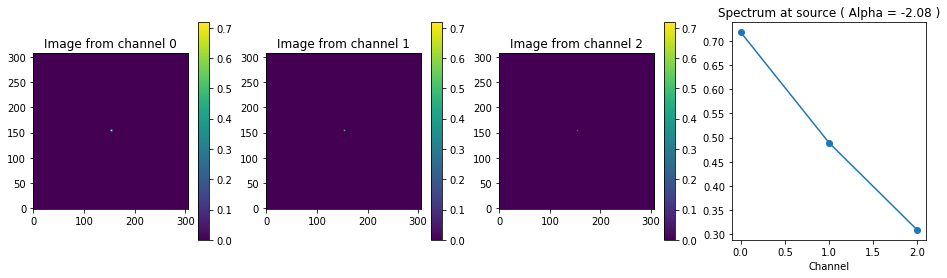

In [224]:
dispImage('try_cube_standard.image', withspec=True)

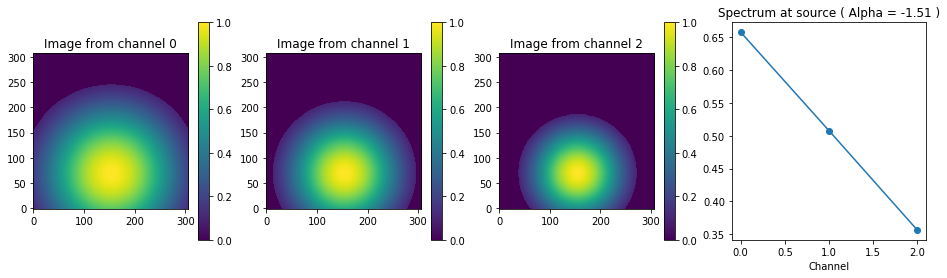

In [225]:
dispImage('try_cube_standard.pb',withspec=True,specloc='mid')

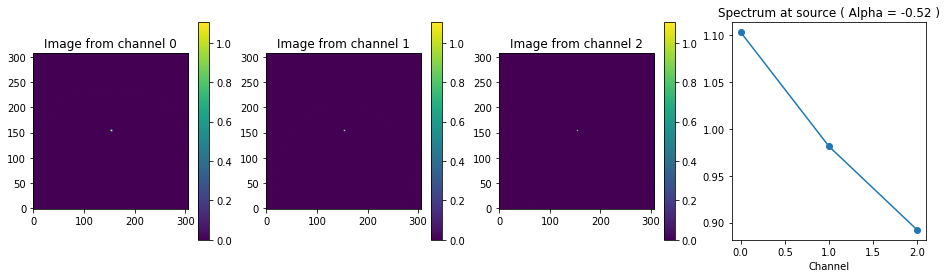

In [226]:
dispImage('try_cube_standard.image.pbcor',withspec=True,specloc='max')

This cube imaging run corrected the spectrum to an accuracy of 0.02. 

__Cube with gridder='mosaic'__
Next, try with gridder='mosaic'.

In [ ]:
imagename = 'try_cube_mosaic'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='cube', 
       gridder='mosaic',
       deconvolver='hogbom', 
       pblimit=-0.1, 
       niter=100, 
       pbcor=True)

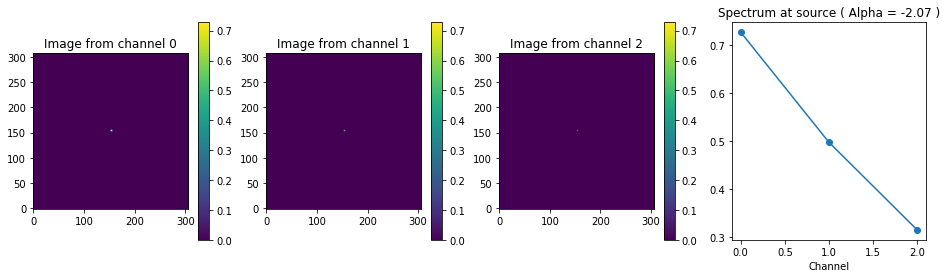

In [227]:
dispImage('try_cube_mosaic.image',withspec=True)

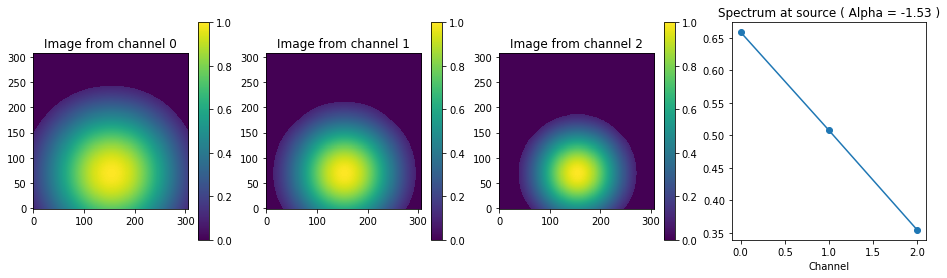

In [228]:
dispImage('try_cube_mosaic.pb',withspec=True,specloc='mid')

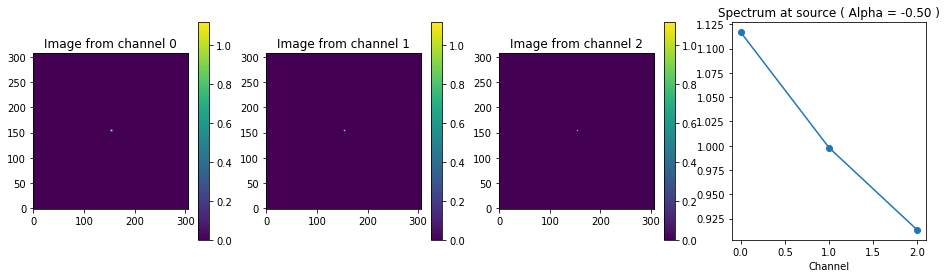

In [229]:
dispImage('try_cube_mosaic.image.pbcor',withspec=True,specloc='max')

This correction is exact.  This is because these data were simulated with the mosaic gridder and the PB spectral model in the dataset exactly matches what gridder='mosaic' calculates during imaging.   


__Cube with gridder='awproject'__

In [ ]:
imagename = 'try_cube_awproject'
#os.system('rm -rf ' + imagename + '.*')    ## If running this multiple times, don't delete the CFCache
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='cube', 
       gridder='awproject',
       deconvolver='hogbom', 
       pblimit=-0.1, 
       niter=100, 
       pbcor=True)

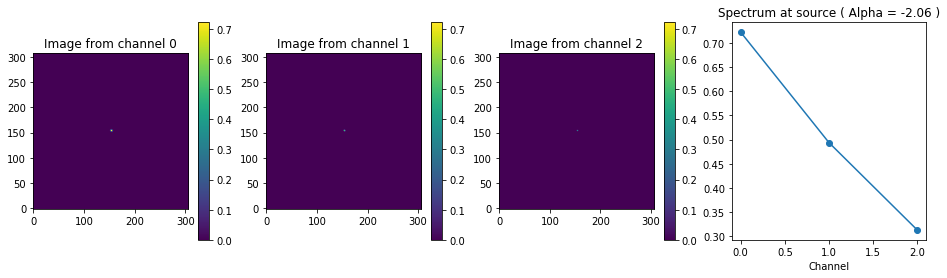

In [230]:
dispImage('try_cube_awproject.image',withspec=True)

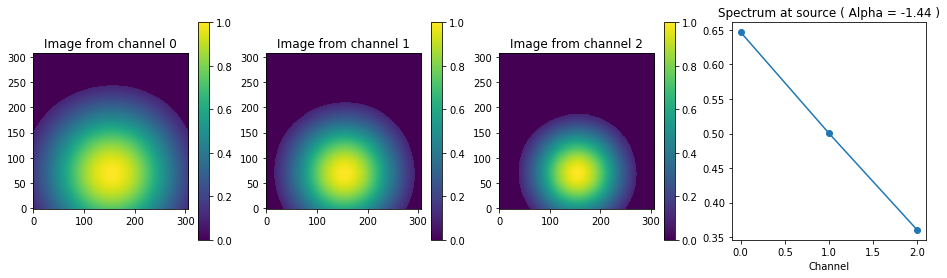

In [231]:
dispImage('try_cube_awproject.pb',withspec=True,specloc='mid')

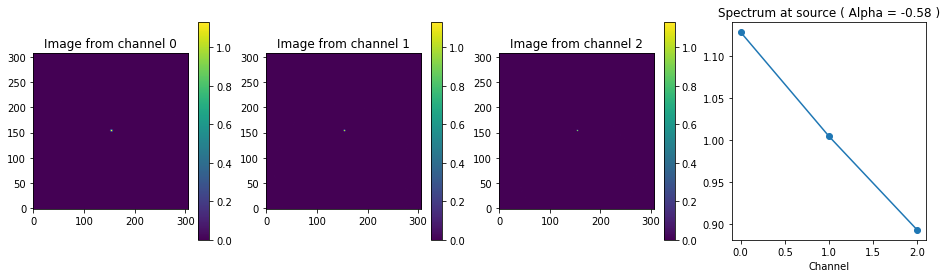

In [232]:
dispImage('try_cube_awproject.image.pbcor',withspec=True,specloc='max')

With gridder='awproject' on a dataset simulated with gridder='mosaic' the PB spectral index correction is accurate to 0.08.

__Point to remember__ : Our PB models are not identical across all of CASA, especially in their frequency dependence. They differ by upto 0.1 in spectral index.


__Obvious Question__ : Which gridder's PB model is closest to reality ?  Our current understanding is "awproject" for azimuthal asymmetry, squint and sidelobes but "mosaic" has the latest L-Band frequency dependence (but is azimuthally symmetric with no sidelobes).  




# MTMFS Imaging with gridder='standard'  + widebandpbcor

The reconstructed multi-term model (and restored) images represent the product of the sky and the PB.
<img src="pic_spec1.png">

Wideband Primary beam correction is a polynomial division of the reconstructed coefficients by PB Taylor coefficients
<img src="pic_spec2.png">


Wideband continuum imaging, using all three channels together. 

In [ ]:
imagename = 'try_mtmfs_standard'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='mfs', 
       gridder='standard',
       deconvolver='mtmfs', 
       nterms=2,
       reffreq='1.5GHz',
       pblimit=-0.1, 
       niter=100, 
       pbcor=True)

widebandpbcor(vis='wbmos.ms', 
              imagename=imagename, 
              field='0',
              nterms=2, 
              reffreq='1.5GHz',
              pbmin=0.1, 
              spwlist=[0,1,2],
              chanlist=[0,0,0], 
              weightlist=[1.0,1.0,1.0])


Choose spwlist, chanlist, weightlist according to the relative sumwt across spectral windows. This matters only if there is about an order of magnitude of systematic difference in data weights across frequency.  If you are not sure about this, just pick one (unflagged!) channel per SPW and set the weightlist to 1.0 for all. 

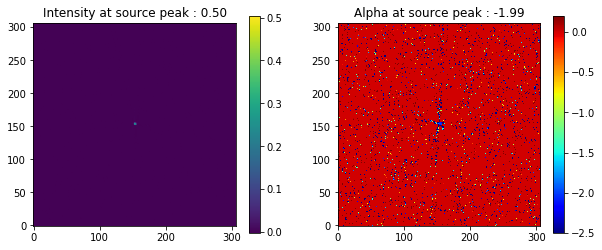

In [208]:
dispImageAlpha(imname='try_mtmfs_standard.image.tt0', alname='try_mtmfs_standard.alpha')

The intensity is at 0.5 (I times PB) and spectral index is -2.0 

Now, display the PB tt0 image and the PB spectral index from the workdirectory made by task widebandpbcor

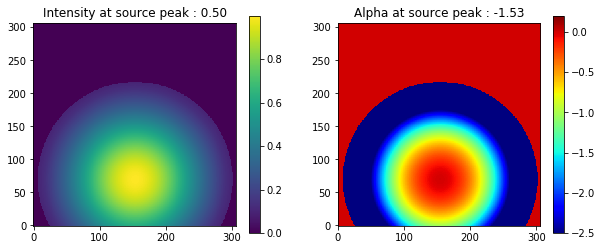

In [234]:
dispImageAlpha(imname='try_mtmfs_standard.pbcor.workdirectory/try_mtmfs_standard.pb.tt0', alname='try_mtmfs_standard.pbcor.workdirectory/try_mtmfs_standard.pb.alpha')

Primary beam intensity is 0.5 and spectral index is -1.53 at the location of the source. The estimate is inaccurate by d_alpha=0.03, and will cause a corresponding error in the output of widebandpbcor. 

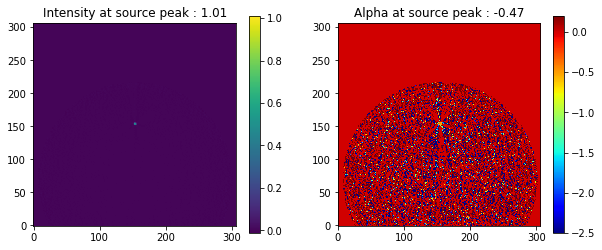

In [235]:
dispImageAlpha(imname='try_mtmfs_standard.pbcor.image.tt0', alname='try_mtmfs_standard.pbcor.image.alpha')

Intensity is accurate now at 1.0, and spectral index is corrected to -0.47 (error is 0.03).   

We can improve accuracy by increasing the number of terms (i.e. nterms=3) in all of the above steps. Even though it is not required for the sky spectrum, the higher order is likely needed for the primary beam spectrum. 

# MTMFS with Wideband A-Projection (gridder='mosaic' and 'awproject'  +  conjbeams=True/False)


A-Projection applies primary beam correction partly in the UV-domain and partly in the image domain.

Gridding convolution functions are constructed as pseudo-inverses of the baseline aperture functions
<img src="pic_spec3.png">
Here, A is an aperture illumination function and P is the square of its Fourier transform (i.e. the primary beam). 

This construction of a convolution function applies corrections for phase effects on the aperture illumination pattern such as (rotation and time-dependent) beam squint and pointing offsets.

Conjbeams is a concept that calculates a pseudo-inverse along the frequency axis as well.  
  
   - Conjbeams = True :  PB frequency dependence is removed during gridding.  The minor cycle sees only the sky spectrum. Partial PB-correction has been done and so the noise will go up away from the PB center.
   - Conjbeams = False : PB frequency dependence is doubled during gridding.  The minor cycle sees sky + twice PB alpha. No PB-correction of amplitude has been done and noise will not go up away from the PB center.
   
__MTMFS with gridder='mosaic' and conjbeams=True__

In [ ]:
imagename = 'try_mtmfs_mosaic'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='mfs', 
       gridder='mosaic',
       conjbeams=True,
       deconvolver='mtmfs', 
       nterms=2,
       reffreq='1.5GHz',
       pblimit=-0.1, 
       niter=100, 
       pbcor=False)


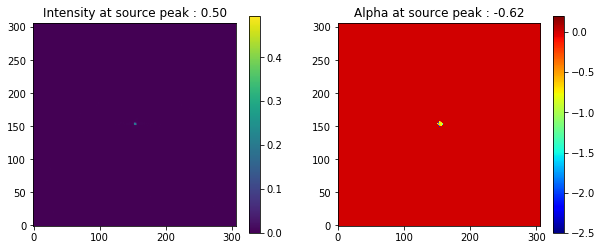

In [236]:
dispImageAlpha(imname='try_mtmfs_mosaic.image.tt0', alname='try_mtmfs_mosaic.alpha')

The spectral index has been corrected (not too accurately). But, the intensity image has not been corrected. 


__Note__ : Even with pbcor=True there is no correction applied to the tt0 image. This is reported clearly in the logger. But, when run from a script this is invisible. 

So, run an explicit impbcor on the tt0 image.

In [ ]:
impbcor(imagename='try_mtmfs_mosaic.image.tt0', 
        pbimage='try_mtmfs_mosaic.pb.tt0', 
        outfile='try_mtmfs_mosaic.pbcor.image.tt0', 
        cutoff=0.1,
        overwrite=True )

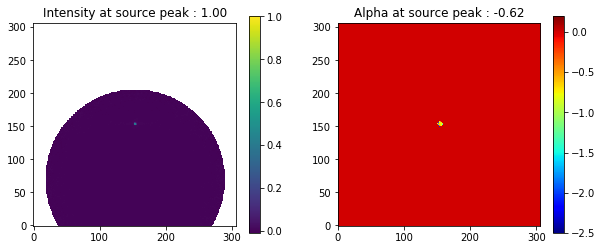

In [237]:
dispImageAlpha(imname='try_mtmfs_mosaic.pbcor.image.tt0', alname='try_mtmfs_mosaic.alpha')

Now, the intensity and spectral index are as close to true as they will get with this setup.

__MTMFS with gridder='awproject' and conjbeams=True__

Try again with awproject.

In [ ]:
imagename = 'try_mtmfs_awproject'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0',
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='mfs', 
       gridder='awproject',       
       conjbeams=True,
       deconvolver='mtmfs', 
       nterms=2,
       reffreq='1.5GHz',
       pblimit=-0.1, 
       niter=100, 
       pbcor=False)


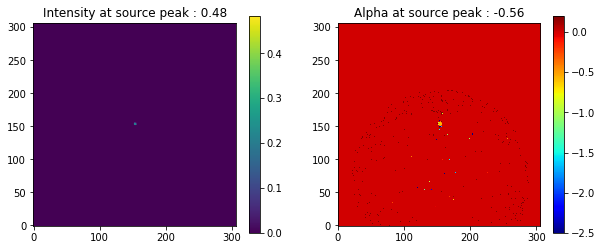

In [238]:
dispImageAlpha(imname='try_mtmfs_awproject.image.tt0', alname='try_mtmfs_awproject.alpha')

In [ ]:
impbcor(imagename='try_mtmfs_awproject.image.tt0', 
        pbimage='try_mtmfs_awproject.pb.tt0', 
        outfile='try_mtmfs_awproject.pbcor.image.tt0', 
        cutoff=0.1,
        overwrite=True )

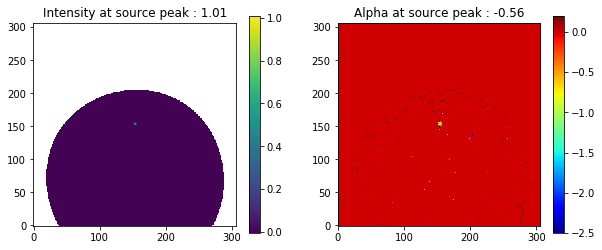

In [239]:
dispImageAlpha(imname='try_mtmfs_awproject.pbcor.image.tt0', alname='try_mtmfs_awproject.alpha')

__Point to note__ : In all of the above imaging runs with the same dataset, the PB-corrected spectral index varied between -0.56, -0.62, -0.47, -0.58, -0.52 with an exact correction to -0.5 obtained only for the imaging run that matched the simulation setup.   Part of this could be numerical errors from the simulation setup ( under investigation ). 

As part of VLASS commissioning, using real data on calibrators of known true spectral index, spectral index accuracies of 0.02 have been demonstrated using mtmfs with awproject and conjbeams=True.  

Further work to reconcile these differences and verify/validate them on real data is ongoing. 



# Overview : Mosaic Primary Beam Spectrum

For a single pointing, the PB spectral index is zero at the center of the pointing and increases away from the center. Therefore, wideband primary beam correction is required only for sources away from the central 10% of the PB. 

For a mosaic, with a fixed pointing separation at all frequencies, there will always be more gain at the lower frequencies compared to the higher ones and there will be a finite PB spectral index across the entire face of the mosaic. Therefore, wideband primary beam correction is required across the entire mosaic and there is no position where the PB alpha is naturally ignorable.   

<img src="pic_overview2.png">

Algorithm options for wideband mosaicing : 

  - Deconvolve Pointings separately or together ( Stitched vs Joint Mosaic )
         - Impacts image fidelity, especially of common sources.

  - Deconvolve Channels separately or together ( Cube vs MFS )
         - Impacts imaging fidelity and sensitivity, dynamic range

  - Use A-Projection or not ( Accurate vs Approximate PB correction )
         - Impacts dynamic range and spectral index accuracy
 

## Cube Mosaic 

This can be done with either gridder='mosaic' or 'awproject'.  This example uses 'mosaic'

In [212]:
imagename = 'try_mos_cube_mosaic'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0,1',   ## Both fields together
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='cube', 
       gridder='mosaic',
       deconvolver='hogbom', 
       pblimit=-0.1, 
       niter=100, 
       pbcor=True)

{}

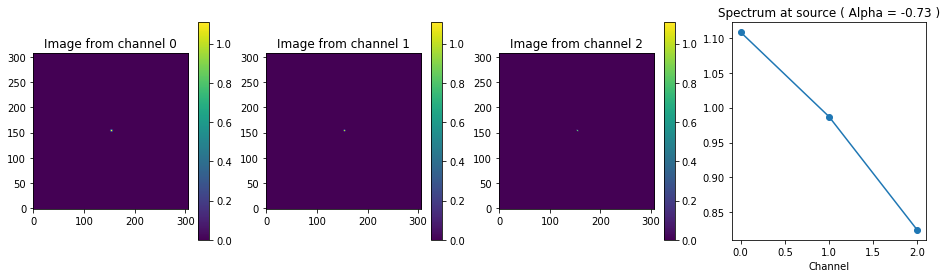

In [213]:
dispImage('try_mos_cube_mosaic.image',withspec=True)

The spectral index of the mosaic primary beam for this example, at the location of the source, is about -0.25. Added to the -0.5 from the sky, we get the ~ -0.75 for the uncorrected spectral index. 

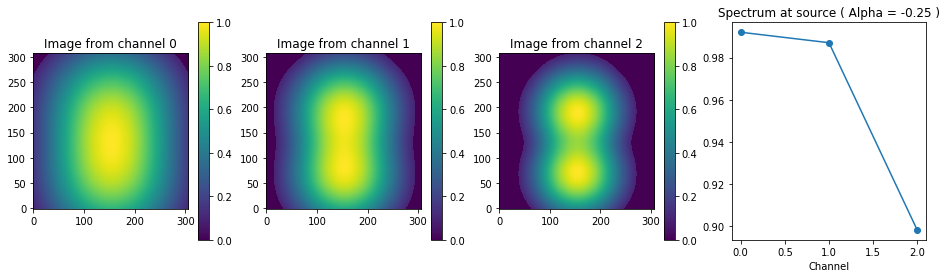

In [214]:
dispImage('try_mos_cube_mosaic.pb',withspec=True,specloc='mid')

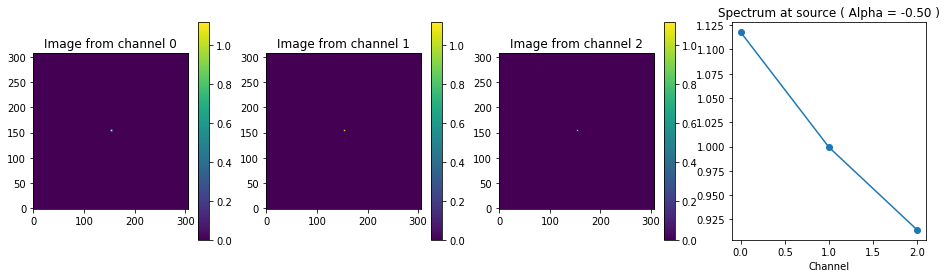

In [215]:
dispImage('try_mos_cube_mosaic.image.pbcor',withspec=True,specloc='max')

Here too, perfect correction when the imaging setup exactly matched the simulation setup. 

         
## Continuum MTMFS 
For a wideband mosaic with accurate PB spectral correction, use gridder='awproject'.  


In [206]:
imagename = 'try_mos_mtmfs_awproject'
os.system('rm -rf ' + imagename + '.*')
casalog.setlogfile(imagename + '.log')

tclean(vis='wbmos.ms',    
       field='0,1',   # Both fields together
       phasecenter = 'J2000 19h59m28.523 +40d54m01.152',
       imagename=imagename, 
       imsize=1024,    
       cell='10.0arcsec', 
       specmode='mfs', 
       gridder='awproject',       
       conjbeams=True,
       deconvolver='mtmfs', 
       nterms=2,
       reffreq='1.5GHz',
       pblimit=-0.1, 
       niter=100, 
       pbcor=False)


{}

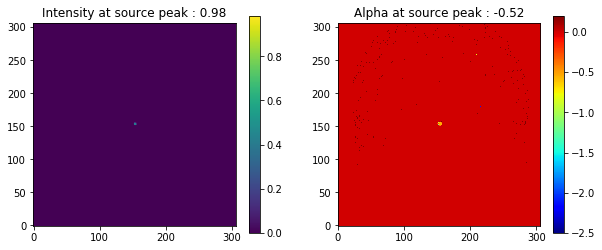

In [209]:
dispImageAlpha(imname='try_mos_mtmfs_awproject.image.tt0', alname='try_mos_mtmfs_awproject.alpha')

In [210]:
impbcor(imagename='try_mos_mtmfs_awproject.image.tt0', 
        pbimage='try_mos_mtmfs_awproject.pb.tt0', 
        outfile='try_mos_mtmfs_awproject.pbcor.image.tt0', 
        cutoff=0.1,
        overwrite=True )

True

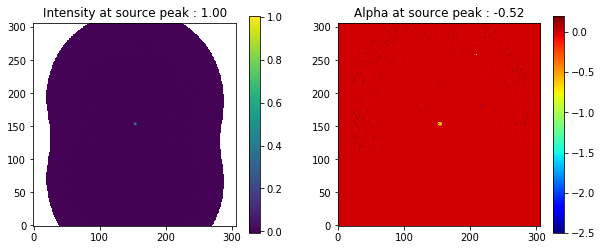

In [211]:
dispImageAlpha(imname='try_mos_mtmfs_awproject.pbcor.image.tt0', alname='try_mos_mtmfs_awproject.alpha')

The intensity is corrected to 1.0 and the spectral index has a remaining error of 0.02.   This is consistent with the known difference in frequency dependence of the PB models between gridder='mosaic' and 'awproject'. 


Note that gridder='mosaic' currently does not produce accurate spectral indices with conjbeams=True and this matter is under investigation as well.   For now, for wideband mosaics, only awproject has been validated. 

# Summary

For single pointings, options are cube+pbcor, mtmfs+widebandpbcor and mtmfs+conjbeams.

For mosaics, options are cube+pbcor ,  mtmfs+conjbeams with awproject.  


__Note__ : Some aspects of wideband primary beam correction, especially for mosaics are not yet perfect. 

   - Differences in CASA primary beam models have implications on accuracy of wideband PB-correction.  The PB spectral index between the 'mosaic' and 'awproject' gridders differ by 0.02 across L-Band. 
   
   - Position-dependent spectral PSFs are also a potential problem at mosaic edges (where the PB spectrum may differ from that at the center) and if uv-coverage and weights vary much over the face of the mosaic. In the ideal situation where the weights are uniform across the face of the mosaic, spectral PSFs generated at the image center will be accurate everywhere except at the edges. The above examples place the source at the image center and therefore the PSF is always made accurately for the source of interest. 
   
   - A third way of implementing widebandpbcorrection along with MTMFS has been prototyped as part of another project and will appear as a option within CASA in the near future (for experimentation/verification). It uses an alternate implementation of the 'conjbeam' concept using a hybrid of cube major cycles with mtmfs minor cycles. 
   
   Algorithm development on these issues is ongoing. 


# Install and Import


__Option 1 : Install local python3__

Instructions to create local python3 virtual environment on Linux and to install casa6 within it. 


    export PPY=`which python3`
    virtualenv -p $PPY --setuptools ./local_python3
    ./local_python3/bin/pip install --upgrade pip
    ./local_python3/bin/pip install --upgrade numpy matplotlib ipython astropy
    ./local_python3/bin/pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatools
    ./local_python3/bin/pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatasks
    ./local_python3/bin/pip3 install jupyter

__Option 2 : Install at runtime__ (for Google Colab)

Instructions to use casa6 on Google Colab

    import os
    print("installing pre-requisite packages...")
    os.system("apt-get install libgfortran3")
    print("installing casatasks...")
    os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatools")
    os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-group/simple casatasks")
    print("building config files...")
    os.system("mkdir ~/.casa")
    !echo home, datapath = \'/content/\', [\'/content/\'] > ~/.casa/toolrc.py
    !more /root/.casa/toolrc.py
    print('complete')
    
***